In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
engine.execute('Select * from Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

print('MEASURMENT COLUMNS')
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
print('STATION COLUMNS')
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

MEASURMENT COLUMNS
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
STATION COLUMNS
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [10]:
import datetime as dt

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest = latest_date[0]
late = latest.split('-')
year = int(late[0])
day = int(late[1])
month = int(late[2])

query_date = dt.date(year, day, month) - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
year_precip = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > query_date).order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
yr_precip_df = pd.DataFrame(year_precip)
yr_precip_df_index = yr_precip_df.set_index("date")
yr_precip_df_index = yr_precip_df_index.sort_index(axis = 0)

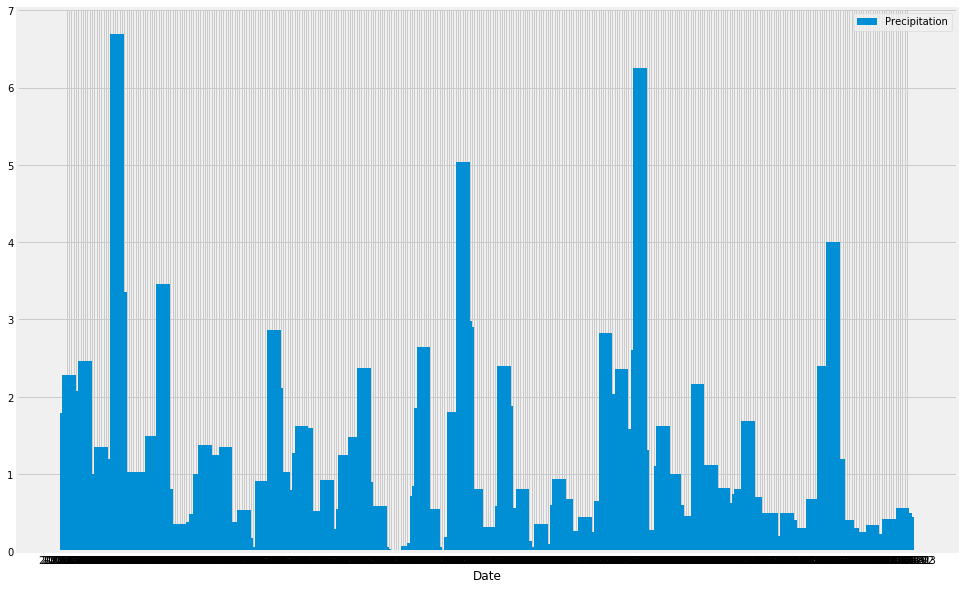

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15,10))
plt.bar(yr_precip_df['date'], yr_precip_df['prcp'],width=6)
plt.legend(labels=['Precipitation'],loc="upper right")
plt.xlabel("Date")
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yr_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?

stations_count = session.query(func.count(Station.id)).all()
stations_count

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

max_stations = session.query(Measurement.station,func.count(Measurement.date)).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()
max_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

# unpack tuples
stations = [result[0] for result in max_stations[:1]]
print(f"The most active station is station {stations[0]}.")
temps = session.query(*sel).filter(Measurement.station == stations[0]).all()
print(f"The minimum, maximum and average temperatures at station {stations[0]} were: {temps[0]}")

The most active station is station USC00519281.
The minimum, maximum and average temperatures at station USC00519281 were: (54.0, 85.0, 71.66378066378067)


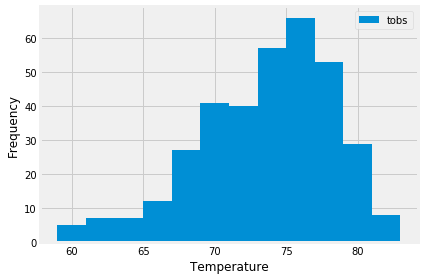

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()
top_station = temp_station[0]

yr_temps = session.query(Measurement.date,Measurement.tobs).filter(Measurement.station == top_station[0]).filter(Measurement.date > query_date).order_by(Measurement.date.desc()).all()
yr_temps_df = pd.DataFrame(yr_temps)

plt.hist(yr_temps_df['tobs'],bins=12)
plt.legend(labels=['tobs'],loc="upper right")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2016-06-27' #one year prior
trip_end_date = '2016-07-04' #one year prior

trip_temps = (calc_temps(trip_start_date, trip_end_date))
trip_temps
print(f"The minimum, average and maximum temperatures for my trip are: {trip_temps}.")

min_temp = [result[0] for result in trip_temps[:1]]
avg_temp = [result[1] for result in trip_temps[:1]]
max_temp = [result[2]for result in trip_temps[:1]]
ptp = max_temp[0]-min_temp[0]

The minimum, average and maximum temperatures for my trip are: [(71.0, 77.19148936170212, 82.0)].


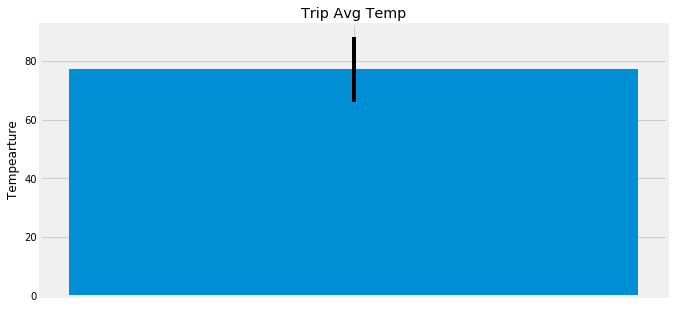

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(10,5))
plt.title("Trip Avg Temp")
plt.ylabel("Tempearture")
plt.bar("", avg_temp, yerr=ptp)
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]
precip_total = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= trip_start_date, Measurement.date <= trip_end_date).order_by(func.sum(Measurement.prcp)).group_by(Station.name).all()

precip_total_df = pd.DataFrame(precip_total, columns=['Station ID','Station Name','latitude','longitude','elevation','precip sum'])
precip_total_df

,Station ID,Station Name,latitude,longitude,elevation,precip sum
0,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.05
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.06
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.20
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.25
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.90
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.01


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_start_date = date(2016,6,27) #'06-27' #one year prior
trip_end_date = date(2016,7,4) #'07-04' #one year prior

# for each date between start and end date calculate daily_norms
# push each tuple of calculations into a list called `normals`
delta = timedelta(days=1)
normals = []
dates = []
while trip_start_date <= trip_end_date:
    norms = (daily_normals(trip_start_date.strftime("%m-%d")))
    dates.append(trip_start_date.strftime("%m-%d"))
    normals.append(norms[0])
    trip_start_date += delta

print(normals)
print(dates)

[(66.0, 75.01785714285714, 81.0), (69.0, 74.88679245283019, 80.0), (67.0, 74.91525423728814, 80.0), (67.0, 75.59615384615384, 81.0), (67.0, 74.77777777777777, 81.0), (68.0, 75.40384615384616, 82.0), (68.0, 75.32075471698113, 87.0), (70.0, 76.57142857142857, 81.0)]
['06-27', '06-28', '06-29', '06-30', '07-01', '07-02', '07-03', '07-04']


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns=['Normal Low Temp','Normal Average Temp', 'Normal High Temp'])
normals_df['Date']=dates
normals_df = normals_df.set_index('Date')
normals_df

,Normal Low Temp,Normal Average Temp,Normal High Temp
Date,,,
06-27,66.0,75.017857,81.0
06-28,69.0,74.886792,80.0
06-29,67.0,74.915254,80.0
06-30,67.0,75.596154,81.0
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0


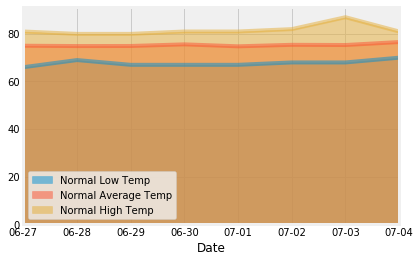

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False)